{'mon/li_msd/mon_300_li.txt': 0.4841013855892264, 'mon/li_msd/mon_400_li.txt': 7.741775335433088, 'mon/li_msd/mon_500_li.txt': 109.8555397506512, 'mon/li_msd/mon_600_li.txt': 413.25485551910066, 'tri/li_msd/tri_300_li.txt': 0.41791500029282097, 'tri/li_msd/tri_400_li.txt': 6.772946423506775, 'tri/li_msd/tri_500_li.txt': 97.73002943866608, 'tri/li_msd/tri_600_li.txt': 445.13771415154804}


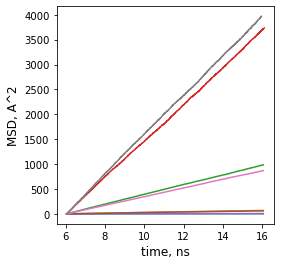

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob

################## Put in parameters! ##################

d = 3 # Dimensionality of ion transport
charge = 1 # Charge of ion
conc = 1.510 * 10**(28) # Concentration of ion
haven = 2.4 # Haven ratio to account for correlation

########################################################

mon = glob.glob('mon/li_msd/*.txt')
tri = glob.glob('tri/li_msd/*.txt')

data = [mon, tri]

########################################################

diffusion_dict = {}
conductivity_dict = {}
conductivity_t_dict = {}

def plot_msd(msd_file):  

    # Import MSD files as lists:
    step, msd = np.loadtxt(msd_file, skiprows=2, unpack=True)
    
    # Find T:
    TT = msd_file[15:]
    T = float(TT[:3])
    
    # Convert to nanoseconds:
    steps = step / 1000000
    
    # Remove initial jump:
    msd = msd - msd[1]

    # Plot MSD:   
    plt.plot(steps, msd)
    
    # Find diffusion coefficient:
    slope, intercept = np.polyfit(steps, msd, 1)
    dc = (slope * (10 ** (-11))) / (2*d)
    diffusion_dict[msd_file] = dc
    
        # Diffusion coefficient = d(msd)/d(t) / 2d
        #
        # unit conversion: A^2 to m^2 is 10**-20; ns to s is 10**9, so unit conversion is 10**-11
    
    # Find conductivity:
    cond = (((charge * 1.602 * 10**(-19))**2 * conc * dc * haven)/((1.381 * 10**(-23)) * T) * 10**(-2))
    conductivity_dict[msd_file] = cond
    conductivity_t_dict[msd_file] = cond * T
    
        # Conversion of diffusion coefficient to conductivity as follows:
        #
        # conducitivity = (charge**2 * charge carrier concentration * diffusion coefficient) / boltzmann constant * temperature
        #
        # charge is electron charge (sodium singularly charged), so 1.602 * 10**(-19) C
        #
        # charge carrier concentration calculated as number of Li/Sc/Cl ions in the simulation cell/cell dimensions
        #
        # diffusion coefficient calcualted as above fromm MSD plot slopes
        #
        # boltzmann constant = 1.381 * 10**(-23) J/K
        #
        # temperature varies with experiment
        #
        # !!! 10**(-2) added to get final results in S/cm as conventionally displayed
    
for dat in data:
    dat.sort()
    for da in dat:
        plot_msd(da)
        
print(conductivity_t_dict)        
    
plt.xlabel('time, ns', size = 12)
plt.ylabel('MSD, A^2', size = 12)

def make_square_axes(ax):
    """Make an axes square in screen units.

    Should be called after plotting.
    """
    ax.set_aspect(1 / ax.get_data_ratio())

make_square_axes(plt.gca())

plt.savefig('msd_red.jpg', bbox_inches='tight', dpi=500)

mon low T: 0.2866564788514775
mon high T: 0.41491873231890697
tri low T: 0.2880340257002188
tri high T: 0.43495860033837114


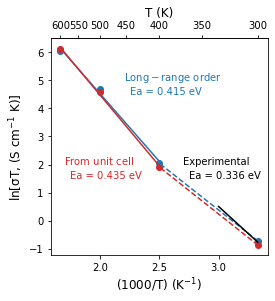

In [9]:
data = ['mon', 'tri']
temp = [300, 400, 500, 600]

colors = ['tab:blue', 'tab:red']

fig, ax = plt.subplots()      

for dat, col in zip(data, colors):
    cond = []
    for x in conductivity_t_dict.keys():
        if x[11:14] == dat:
            cond.append(conductivity_t_dict[x])
    ln_cond = np.log(cond) 
    
    rec_temp = []
    for t in temp:
        rec_temp.append(1000/t)
    
    ax.scatter(rec_temp, ln_cond, color=col)
    
    m, c = np.polyfit(rec_temp[1:], ln_cond[1:], 1)
    m2, c2 = np.polyfit(rec_temp[:2], ln_cond[:2], 1)
    
    extra = []
    extra2 = []
    
    for rect in rec_temp:
        extra.append(m*rect+c)
        
    for rect in rec_temp:
        extra2.append(m2*rect+c2)
        
    ax.plot(rec_temp[1:], extra[1:], ls='-', color=col)    
    ax.plot(rec_temp[:2], extra2[:2], ls='--', color=col)
    
    ea = -1000 * m * 1.380649 * 10**(-23) * 6.241509 * 10**18
    ea2 = -1000 * m2 * 1.380649 * 10**(-23) * 6.241509 * 10**18
    
    # Conversion of conductivity to activation energy as follows:
    # ln(conductivity * T) = -Ea/kT
    # Ea = - ln(conductivity * T) * kT
    #
    # slope = ln(conductivity * T) / (1000/T)
    #
    # Ea = -1000 * slope * k
    #
    # Ea (in eV) = -1000 * slope * k * 1/e
    
    print(f'{dat} low T: {ea2}')
    print(f'{dat} high T: {ea}')
    
ax.set_xlabel('(1000/T) (K$^\mathrm{-1}$)', size = 12)
ax.set_ylabel('ln[$\mathrm{\sigma}$T, (S cm$^\mathrm{-1}$ K)]', size = 12)

ax.plot([3.00, 3.33], [0.51, -0.76], color='black')

#ax.scatter(3.33, -0.90, color='black', zorder=1)

ax.text(2.2, 5, '$\mathrm{Long-range\ order}$', color='tab:blue', size=10)
ax.text(2.25, 4.5, 'Ea = 0.415 eV', color='tab:blue', size=10)

ax.text(1.7, 2, '$\mathrm{From\ unit\ cell}$', color='tab:red', size=10)
ax.text(1.75, 1.5, 'Ea = 0.435 eV', color='tab:red', size=10)

#ax.text(2, 6.5, '$\mathrm{Li_{17}Sc_{2.5}In_{2.5}Cl_{32}:}$', color='tab:gray', size=10)
#ax.text(2.2, 6, 'Ea = 0.422 eV', color='tab:gray', size=10)

#ax.text(1.7, 2.3, '$\mathrm{Li_{17}Sc_{2.5}Y_{2.5}Cl_{32}:}$', color='tab:purple', size=10)
#ax.text(1.9, 1.8, 'Ea = 0.424 eV', color='tab:purple', size=10)

ax.text(2.7, 2, 'Experimental', color='black', size=10)
ax.text(2.75, 1.5, 'Ea = 0.336 eV', color='black', size=10)

def invert(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = (1 / x[~near_zero])*1000
    return x

secax = ax.secondary_xaxis('top', functions=(invert, invert))
secax.set_xlabel('T (K)', size = 12)

def make_square_axes(ax):
    """Make an axes square in screen units.

    Should be called after plotting.
    """
    ax.set_aspect(1 / ax.get_data_ratio())

make_square_axes(plt.gca())

plt.savefig('lnconductivity_li_stage1.jpg', bbox_inches='tight', dpi=500)